In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline
version = '03'

## Dataset loading

In [3]:
right = pd.read_csv("../data/right.txt", header=None).values.tolist()
left = pd.read_csv("../data/left.txt", header=None).values.tolist()

## Pre-processing

In [4]:
batch_size = 200
batch_right = [right[i:i + batch_size] for i in range(0, len(right), batch_size)]
batch_left = [left[i:i + batch_size] for i in range(0, len(left), batch_size)]

X = np.array(batch_right + batch_left)
y = np.array([0]*len(batch_right) + [1]*len(batch_left))

In [5]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (600, 200, 2)
y shape: (600,)


In [6]:
X_diff = X[:,:-1,:].copy()
X_diff[:,:,0] = np.diff(X[:,:,0])
X_diff[:,:,1] = np.diff(X[:,:,1])

Text(0.5, 0, 'y relative movement (px)')

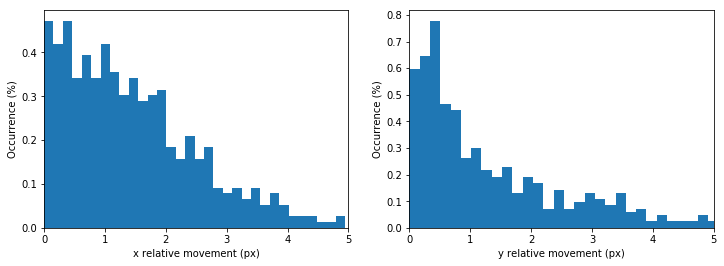

In [8]:
sigma_x = np.std(X_diff[:,:,0], axis=1)
sigma_y = np.std(X_diff[:,:,1], axis=1)

X_filt = X_diff[(sigma_x>0.1)*(sigma_y>0.1)]

x_std = 3.398 # np.mean(np.std(X_filt[:,:,0], axis=1))
y_std = 2.926 # np.mean(np.std(X_filt[:,:,1], axis=1))

X_filt[:,:,0] = X_filt[:,:,0] / x_std
X_filt[:,:,1] = X_filt[:,:,1] / y_std

sigma_x_filt = np.std(X_filt[:,:,0], axis=1)
sigma_y_filt = np.std(X_filt[:,:,1], axis=1)


fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12, 4))
ax1.hist(sigma_x_filt, bins=50, density=True)
ax2.hist(sigma_y_filt, bins=50, density=True)
for ax in (ax1,ax2):
    ax.set_xlim(0,5)
    ax.set_ylabel('Occurrence (%)')
    #ax.set_yticks(np.arange(0,0.41,0.1))
ax1.set_xlabel('x relative movement (px)')
ax2.set_xlabel('y relative movement (px)')

#fig.savefig(f'../plots/relative_movement_hist_corrected.png', bbox_inches='tight')

In [13]:
np.mean(np.std(X_filt[:,:,0], axis=1))

1.4900517595356684

## Training/dev/test set splitting

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
X_dev, X_test, y_dev, y_test = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

## Model definition

In [15]:
model = Sequential()
model.add(LSTM(256, input_shape=(batch_size, 2)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               265216    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 265,473
Trainable params: 265,473
Non-trainable params: 0
_________________________________________________________________


## Model training

In [21]:
adam = Adam(lr=0.1)
chk = ModelCheckpoint(f'../models/best_model_{version}.pkl', monitor='acc', save_best_only=True, mode='max', verbose=0) #monitor='val_acc'
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history_training = model.fit(X_train, y_train, epochs=200, batch_size=64, callbacks=[chk], validation_data=(X_dev, y_dev))

Train on 420 samples, validate on 210 samples
Epoch 1/200
420/420 [==============================] - 3s 8ms/step - loss: 0.8724 - acc: 0.4976 - val_loss: 1.5033 - val_acc: 0.4524
Epoch 2/200
420/420 [==============================] - 2s 4ms/step - loss: 0.8898 - acc: 0.5238 - val_loss: 0.6756 - val_acc: 0.6286
Epoch 3/200
420/420 [==============================] - 2s 4ms/step - loss: 0.6924 - acc: 0.5524 - val_loss: 0.6733 - val_acc: 0.6095
Epoch 4/200
420/420 [==============================] - 2s 4ms/step - loss: 0.6999 - acc: 0.5167 - val_loss: 0.7108 - val_acc: 0.5476
Epoch 5/200
420/420 [==============================] - 2s 4ms/step - loss: 0.7162 - acc: 0.4833 - val_loss: 0.7543 - val_acc: 0.4524
Epoch 6/200
420/420 [==============================] - 2s 4ms/step - loss: 0.7120 - acc: 0.5119 - val_loss: 0.7070 - val_acc: 0.4524
Epoch 7/200
420/420 [==============================] - 2s 5ms/step - loss: 0.7242 - acc: 0.5310 - val_loss: 0.6978 - val_acc: 0.5476
Epoch 8/200
420/420 [==

Epoch 62/200
420/420 [==============================] - 3s 6ms/step - loss: 0.8027 - acc: 0.5167 - val_loss: 0.6963 - val_acc: 0.5571
Epoch 63/200
420/420 [==============================] - 3s 6ms/step - loss: 0.7126 - acc: 0.4952 - val_loss: 0.7960 - val_acc: 0.4524
Epoch 64/200
420/420 [==============================] - 3s 6ms/step - loss: 0.8174 - acc: 0.5262 - val_loss: 1.0782 - val_acc: 0.4524
Epoch 65/200
420/420 [==============================] - 3s 6ms/step - loss: 0.8287 - acc: 0.5167 - val_loss: 0.9535 - val_acc: 0.4524
Epoch 66/200
420/420 [==============================] - 2s 6ms/step - loss: 0.7517 - acc: 0.4738 - val_loss: 0.6857 - val_acc: 0.5571
Epoch 67/200
420/420 [==============================] - 3s 6ms/step - loss: 0.7187 - acc: 0.5452 - val_loss: 0.6970 - val_acc: 0.5571
Epoch 68/200
420/420 [==============================] - 3s 7ms/step - loss: 0.7244 - acc: 0.4976 - val_loss: 0.6892 - val_acc: 0.5571
Epoch 69/200
420/420 [==============================] - 3s 7ms

Epoch 123/200
420/420 [==============================] - 2s 6ms/step - loss: 0.7036 - acc: 0.5143 - val_loss: 0.7163 - val_acc: 0.4524
Epoch 124/200
420/420 [==============================] - 2s 5ms/step - loss: 0.7128 - acc: 0.5024 - val_loss: 0.7699 - val_acc: 0.4524
Epoch 125/200
420/420 [==============================] - 2s 6ms/step - loss: 0.7390 - acc: 0.4429 - val_loss: 0.7207 - val_acc: 0.5571
Epoch 126/200
420/420 [==============================] - 3s 6ms/step - loss: 0.7293 - acc: 0.5262 - val_loss: 0.7536 - val_acc: 0.5571
Epoch 127/200
420/420 [==============================] - 3s 6ms/step - loss: 0.8817 - acc: 0.5190 - val_loss: 0.6906 - val_acc: 0.5571
Epoch 128/200
420/420 [==============================] - 3s 6ms/step - loss: 0.7211 - acc: 0.5214 - val_loss: 0.7420 - val_acc: 0.4524
Epoch 129/200
420/420 [==============================] - 3s 6ms/step - loss: 0.7100 - acc: 0.4762 - val_loss: 0.6989 - val_acc: 0.4524
Epoch 130/200
420/420 [==============================] 

420/420 [==============================] - 3s 7ms/step - loss: 0.7139 - acc: 0.5000 - val_loss: 0.8089 - val_acc: 0.4524
Epoch 184/200
420/420 [==============================] - 3s 7ms/step - loss: 0.7752 - acc: 0.4571 - val_loss: 0.7585 - val_acc: 0.5571
Epoch 185/200
420/420 [==============================] - 2s 6ms/step - loss: 0.7360 - acc: 0.5119 - val_loss: 0.7063 - val_acc: 0.5571
Epoch 186/200
420/420 [==============================] - 2s 6ms/step - loss: 0.7398 - acc: 0.5190 - val_loss: 0.7201 - val_acc: 0.4524
Epoch 187/200
420/420 [==============================] - 2s 6ms/step - loss: 0.7354 - acc: 0.5024 - val_loss: 0.8610 - val_acc: 0.4524
Epoch 188/200
420/420 [==============================] - 2s 6ms/step - loss: 0.7583 - acc: 0.5214 - val_loss: 0.7055 - val_acc: 0.4524
Epoch 189/200
420/420 [==============================] - 2s 6ms/step - loss: 0.7053 - acc: 0.5524 - val_loss: 0.6971 - val_acc: 0.4524
Epoch 190/200
420/420 [==============================] - 2s 6ms/step 

## Training history plot

Best accuracy on the dev set: 62.9%
Best accuracy on the training set: 56.2%


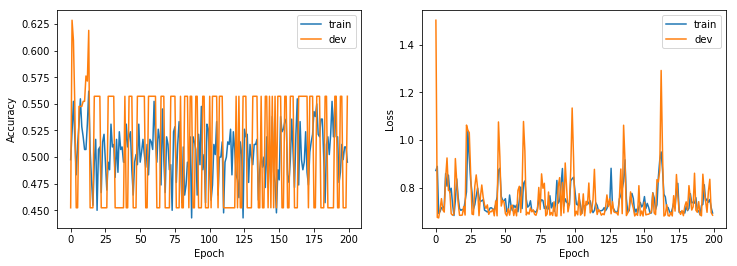

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(history_training.history['acc'], label='train')
ax1.plot(history_training.history['val_acc'], label='dev')

ax2.plot(history_training.history['loss'], label='train')
ax2.plot(history_training.history['val_loss'], label='dev')

ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.legend()
ax2.legend()

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

best_acc = max(history_training.history['val_acc'])
print(f'Best accuracy on the dev set: {best_acc*100:.1f}%')
best_acc_training = max(history_training.history['acc'])
print(f'Best accuracy on the training set: {best_acc_training*100:.1f}%')
#fig.savefig(f'../plots/model_{version}.png', bbox_inches='tight')

## Evaluation of the model

In [23]:
model = load_model(f'../models/best_model_{version}.pkl') # load best model

In [24]:
dev_preds = model.predict_classes(X_dev)
acc_dev = accuracy_score(y_dev, dev_preds)
print(f'Accuracy on the dev set: {acc_dev*100:.1f}%')

training_preds = model.predict_classes(X_train)
acc_training = accuracy_score(y_train, training_preds)
print(f'Accuracy on the training set: {acc_training*100:.1f}%')

Accuracy on the dev set: 61.9%
Accuracy on the training set: 57.4%


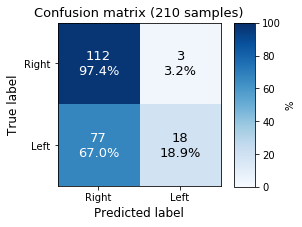

In [25]:
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_dev, dev_preds)

classes=['Right', 'Left']
fig, ax = plt.subplots(1, figsize=(3,3))
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

cm_norm = cm / cm.sum(axis=1)*100
im = ax.imshow(cm_norm, cmap='Blues', interpolation='none', clim=(0,100))
ax.set_title(f'Confusion matrix ({y_dev.shape[0]} samples)', size=13)


for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, f'{cm[i,j]}\n{cm_norm[i, j]:.1f}%', size=13,
             horizontalalignment="center", verticalalignment="center",
             color="white" if cm[i, j] > 60 else "black")
ax.set_ylabel('True label', size=12)
ax.set_xlabel('Predicted label', size=12)

cb_ax = fig.add_axes([0.95, 0.12, 0.1, 0.76])
cb = fig.colorbar(im, cax=cb_ax, orientation='vertical')
cb.set_label('%')

fig.savefig(f'../plots/conf_matrix_{version}.png', bbox_inches='tight')